# "SberAutopodpiska": prediction of targeted actions

**Goal of the project**: to predict the occurrence of one of the target actions - events like "Leave a request" or "Order a call" for each session by the attributes visit_\*, utm_\*, device_\*, geo_\*.

**Target metric**: roc-auc > 0.65.

## Notebook setup

### Import libraries





In [1]:
! pip install feature-engine==1.4.0 catboost==1.1.1 bayesian-optimization==1.4.1

  Using cached feature_engine-1.4.0-py2.py3-none-any.whl (276 kB)
  Attempting uninstall: feature-engine
    Found existing installation: feature-engine 1.6.0
    Uninstalling feature-engine-1.6.0:
      Successfully uninstalled feature-engine-1.6.0


In [2]:
import sys
from datetime import datetime
import warnings
from pathlib import Path
from typing import Union
from functools import partial

import dill
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and metrics
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold)
from sklearn.metrics import(
    roc_auc_score, accuracy_score, confusion_matrix, precision_score,
    recall_score, f1_score, make_scorer, roc_curve)
from sklearn.pipeline import Pipeline
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.outliers import Winsorizer
from feature_engine.selection import (
    DropDuplicateFeatures, DropConstantFeatures,
    DropCorrelatedFeatures, DropFeatures)
from feature_engine.transformation import YeoJohnsonTransformer
from bayes_opt import BayesianOptimization

# models
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import(
    RandomForestClassifier, HistGradientBoostingClassifier)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Additional information
from additional_data import(
    get_distance_from_moscow, target_events, missing_values, organic_mediums,
    social_media_sources, moscow_region_cities, big_cities, russian_holidays)

### Creating constants

In [3]:
TEST_SIZE = 200_000
RANDOM_SEED = 0

### Notebook setup

In [4]:
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

### Loading data

For the `ga_hits.csv` file, only the 'session_id' and 'event_action' columns need to be loaded, since the others are not used.

In [5]:
sessions = pd.read_csv('data/ga_sessions.csv', dtype={"client_id": "string"})
hits = pd.read_csv('data/ga_hits.csv', usecols=['session_id', 'event_action'])

## Data preparation

### Target variable

The target variable is considered positive if the session from `sessions` has at least one target event in `hits`.

In [6]:
hits['target'] = hits['event_action'].isin(target_events)
is_target_event = hits.groupby('session_id')['target'].any().astype(int)

In [7]:
target = pd.Series(is_target_event, index=sessions['session_id']).fillna(0.0)
target.value_counts(dropna=False, normalize=True)

0.0    0.97295
1.0    0.02705
Name: target, dtype: float64

In [8]:
del hits

### Fill in the blanks

Gaps in the `device_screen_resolution` column are filled with the most frequent value.
All other gaps in the columns are filled with the value '(nan)'.

In [9]:
def fill_missings(data: pd.DataFrame) -> pd.DataFrame:
    """Fills in missing values:
    * the most common value for `device_screen_resolution`;
    * value '(nan)' in all other cases.
    """

    data = data.copy()

    if 'device_screen_resolution' in data.columns:
        # '414x896' is the most frequent value in 'device_screen_resolution'
        # according to preliminary data analysis
        data['device_screen_resolution'] = data['device_screen_resolution'].replace(missing_values, '414x896')
    
    return data.fillna('(nan)')

### Generation of features

A lot of additional variables are created: day of the week and day of the month, whether the day is a weekend, the hour and minute of the visit, whether the visit is at night, width, height, area and screen ratio.

Including with additional data: whether the day is a holiday, whether the traffic is organic, whether it comes from social networks, whether the user is in a big city or in the Moscow region, the distance to Moscow, both numerically and in the form of categories.

In [10]:
def distance_category(distance: float) -> str:
    """
    Returns the distance category to Moscow.
    """

    if distance == -1: return 'no distance'
    elif distance == 0: return 'moscow'
    elif distance < 100: return '< 100 km'
    elif distance < 500: return '100-500 km'
    elif distance < 1000: return '500-1000 km'
    elif distance < 3000: return '1000-3000 km'
    else: return '>= 3000 km'

In [11]:
def create_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Creates new features from existing ones.
    """

    data = data.copy()
    
    # visit_date signs
    if 'visit_date' in data.columns:
        data['visit_date'] = data['visit_date'].astype('datetime64[ns]')
        data['visit_date_added_holiday'] = \
            data['visit_date'].isin(russian_holidays)
        # make numerical features strictly positive
        # for better handling in step with YeoJohnsonTransformer
        data['visit_date_weekday'] = data['visit_date'].dt.weekday + 1
        data['visit_date_weekend'] = data['visit_date'].dt.weekday > 4
        data['visit_date_day'] = data['visit_date'].dt.day + 1

    # visit_time signs
    if 'visit_time' in data.columns:
        data['visit_time'] = data['visit_time'].astype('datetime64[ns]')
        data['visit_time_hour'] = data['visit_time'].dt.hour + 1
        data['visit_time_minute'] = data['visit_time'].dt.minute + 1
        data['visit_time_night'] = data['visit_time'].dt.hour < 9

    # utm_* signs
    if 'utm_medium' in data.columns:
        data['utm_medium_added_is_organic'] = \
            data['utm_medium'].isin(organic_mediums)
    if 'utm_source' in data.columns:
        data['utm_source_added_is_social'] = \
            data['utm_source'].isin(social_media_sources)
    
    # device_screen features
    if 'device_screen_resolution' in data.columns:
        name='device_screen_resolution'
        data[[name + '_width', name + '_height']] = \
            data[name].str.split('x', expand=True).astype(float)
        data[name + '_area'] = data[name + '_width'] * data[name + '_height']
        data[name + '_ratio'] = data[name + '_width'] / data[name + '_height']
        data[name + '_ratio_greater_1'] = data[name + '_ratio'] > 1

    # geo_city features
    if 'geo_city' in data.columns:
        data['geo_city_added_is_moscow_region'] = \
            data['geo_city'].isin(moscow_region_cities)
        data['geo_city_added_is_big'] = data['geo_city'].isin(big_cities)
        data['geo_city_is_big_or_in_moscow_region'] = \
            data['geo_city_added_is_moscow_region'] \
            | data['geo_city_added_is_big']
        data['geo_city_added_distance_from_moscow'] = \
            data['geo_city'].apply(get_distance_from_moscow)
        data['geo_city_added_distance_from_moscow_category'] = \
            data['geo_city_added_distance_from_moscow'].apply(distance_category)

    return data

### Additional

In [12]:
def set_index(data: pd.DataFrame, column: str = 'session_id') -> pd.DataFrame:
    """
    Sets the dataframe index to the `column` column.
    """
    
    data = data.copy()

    if column in data.columns:
        data = data.set_index(column)
    
    return data

In [13]:
def converse_types(data: pd.DataFrame) -> pd.DataFrame:
    """
    Casts variable types to float. First of all needed to convert bool values.
    """

    return data.astype(float)

### Conveyor assembly

The data preparation pipeline consists of 4 parts:
1. Creation of additional features
2. Transformation of numerical variables
3. Transformation of categorical variables
4. Removing unnecessary features

In [14]:
preprocessor = Pipeline(steps=[

    # Create additional features and
    # Bringing the dataframe to a convenient form
    ('indexer', FunctionTransformer(set_index)),
    ('imputer', FunctionTransformer(fill_missings)),
    ('engineer', FunctionTransformer(create_features)),
    ('dropper', DropFeatures(['client_id', 'visit_date', 'visit_time', 'device_screen_resolution'])),

    # Transformations of numerical variables
    ('normalization', YeoJohnsonTransformer()),
    ('outlier_remover', Winsorizer()),
    ('scaler', SklearnTransformerWrapper(StandardScaler())),

    # Transformations of categorical features
    ('rare_encoder', RareLabelEncoder(tol=0.05, replace_with='rare')),
    ('onehot_encoder', OneHotEncoder(drop_last_binary=True)),
    ('bool_converter', FunctionTransformer(converse_types)),

    # Removing duplicates and correlated features
    ('constant_dropper', DropConstantFeatures(tol=0.99)),
    ('duplicated_dropper', DropDuplicateFeatures()),
    ('correlated_dropper', DropCorrelatedFeatures(threshold=0.8)),

])

## Modeling

### Data separation

We divide the data into training, validation and test sets.

In [15]:
X, X_test, y, y_test = train_test_split(
    sessions, target, test_size=TEST_SIZE, 
    stratify=target, random_state=RANDOM_SEED)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=TEST_SIZE, 
    stratify=y, random_state=RANDOM_SEED)

print(f'train shapes: {X_train.shape} {y_train.shape}')
print(f'valid shapes: {X_valid.shape} {y_valid.shape}')
print(f'test  shapes: {X_test.shape} {y_test.shape}')

train shapes: (1460042, 18) (1460042,)
valid shapes: (200000, 18) (200000,)
test  shapes: (200000, 18) (200000,)


### Data preprocessing

Transform the training and validation data using the constructed pipeline.

In [16]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

print(f'X_train.shape = {X_train_preprocessed.shape}')

X_train.shape = (1460042, 55)


### Choice of metrics

We will use `roc_auc` as the main metric. But let's also look at other metrics: `accuracy`, `precision`, `recall`, `f1`.

In [17]:
def find_best_threshold(
    y_true: pd.Series, 
    y_proba: pd.Series, 
    metriс_name: str = 'roc_auc', 
    iterations: int = 250, 
    learning_rate: float = 0.05
) -> float:
    """
    Finds the best translation threshold for `y_proba` probabilities in class 1.
    """
    
    # Getting the function of the metric that we optimize
    metrics = {'roc_auc': roc_auc_score, 'f1': f1_score, 
               'precision': precision_score, 'recall': recall_score}
    metric_function = metrics.get(metriс_name, accuracy_score)

    # Getting metric
    def get_metric(threshold: float) -> float:
        prediction = (y_proba > threshold).astype(int)
        return metric_function(y_true, prediction)

    direction = -1
    shift = 0.25

    best_threshold = 0.5
    best_metric = get_metric(best_threshold)

    # At every iteration
    for i in range(iterations):

        # Change the threshold
        threshold = best_threshold + direction * shift
        shift *= (1 - learning_rate)
        metric = get_metric(threshold)

        # And check if the metric has improved
        if metric > best_metric: 
            best_threshold = threshold
            best_metric = metric
        else: 
            direction *= -1
            
    return best_threshold

In [18]:
def print_metrics(
    model: BaseEstimator, 
    X: pd.DataFrame, 
    y: pd.Series, 
    threshold: Union[float, None] = None, 
    show_roc_curve: bool = False
) -> None:
    """
    Gets binary classification metrics from `model` on the data `X` and `y`. 
    If possible, then through the `predict_proba` method with the given
    threshold for translating probabilities into `threshold` classes, otherwise through `predict`.
    If `threshold` is None, it will automatically find the best threshold.
    ---
    Metrics: roc_auc, accuracy, precision, recall, f1, confusion_matrix, roc_curve.
    """

    # Get predictions, if possible, in the form of probabilities
    try: 
        probas = model.predict_proba(X)[:, 1]
    except AttributeError:
        prediction = model.predict(X)
        threshold = None
        probas = None
    else:
        threshold = threshold or find_best_threshold(y, probas, 'roc_auc')
        prediction = (probas > threshold).astype(int)

    # Print the threshold for translating probabilities into classes
    if threshold is None:
        print("Threshold for translating probabilities into classes: not used")
    else:
        print(f"Threshold for translating probabilities into classes: {threshold}")
        print(f"{roc_auc_score(y, probas)} - roc_auc on probabilities")

    # Print one-line metrics
    print()
    print(f"{roc_auc_score(y, prediction):0.8f} - roc_auc")
    print(f"{accuracy_score(y, prediction):0.8f} - accuracy")
    print(f"{precision_score(y, prediction):0.8f} - precision")
    print(f"{recall_score(y, prediction):0.8f} - recall")
    print(f"{f1_score(y, prediction):0.8f} - f1")

    # Print out the error matrix
    conf_mat = confusion_matrix(y, prediction)
    classes = model.classes_
    n_classes = len(classes)
    print()
    print("|".join(f"{i:^10}" for i in ["prediction"] + list(classes)))
    print(f"{'true label':^10}" + ("|" + " " * 10) * n_classes)
    print("-" * ((n_classes * 10) + n_classes + 10))
    for i in range(n_classes):
        print("|".join(f"{j:>10}" for j in [classes[i]] + list(conf_mat[i])))

    # Display the ROC curve
    if show_roc_curve:
        print()
        plt.figure(figsize=(7, 4))
        if probas is not None:
            plt.plot(*roc_curve(y_test, probas)[:2], 
                     c='r', label='on probability')
        plt.plot(*roc_curve(y_test, prediction)[:2], c='b', label='on class')
        plt.plot([0, 1], [0, 1], c='y', label='random', linestyle='dashed')
        plt.title('Receiver operating characteristic')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

### Base model

Since the target variable is not evenly distributed, then as a baseline, you can choose a strategy that predicts the value 0 for each session.

In [19]:
# Train the base model
baseline = DummyClassifier(strategy='constant', constant=0)
baseline.fit(X_train_preprocessed, y_train)

# And get its metrics
print_metrics(baseline, X_valid_preprocessed, y_valid, 0.5)

Threshold for translating probabilities into classes: 0.5
0.5 - roc_auc on probabilities

0.50000000 - roc_auc
0.97295000 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    194590|         0
       1.0|      5410|         0


### Model selection

We will train several models, evaluate them on the validation set and choose the best one, which we will already optimize.

Logistic regression

In [20]:
logreg = LogisticRegression(random_state=RANDOM_SEED)

In [21]:
%%time
logreg.fit(X_train_preprocessed, y_train);

CPU times: user 1min 21s, sys: 22.4 s, total: 1min 44s
Wall time: 27.1 s


In [22]:
print_metrics(logreg, X_valid_preprocessed, y_valid)

Threshold for translating probabilities into classes: 0.5
0.6683645161697864 - roc_auc on probabilities

0.50000000 - roc_auc
0.97295000 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    194590|         0
       1.0|      5410|         0


Support vector classifier

In [23]:
svc = LinearSVC(class_weight='balanced')

In [24]:
%%time
svc.fit(X_train_preprocessed, y_train);

CPU times: user 16min 21s, sys: 1.04 s, total: 16min 22s
Wall time: 16min 23s


In [25]:
print_metrics(svc, X_valid_preprocessed, y_valid)

Threshold for translating probabilities into classes: not used

0.62072316 - roc_auc
0.61829500 - accuracy
0.04341165 - precision
0.62329020 - recall
0.08116989 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    120287|     74303
       1.0|      2038|      3372


Neural network

In [26]:
mlp = MLPClassifier((32,), random_state=RANDOM_SEED)

In [27]:
%%time
mlp.fit(X_train_preprocessed, y_train);

CPU times: user 6min 38s, sys: 4min 58s, total: 11min 37s
Wall time: 2min 59s


In [28]:
print_metrics(mlp, X_valid_preprocessed, y_valid)

Threshold for translating probabilities into classes: 0.5
0.6983782119645087 - roc_auc on probabilities

0.50000000 - roc_auc
0.97295000 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    194590|         0
       1.0|      5410|         0


Bayesian classifier

In [29]:
gaussnb = GaussianNB()

In [30]:
%%time
gaussnb.fit(X_train_preprocessed, y_train);

CPU times: user 1.21 s, sys: 580 ms, total: 1.79 s
Wall time: 1.79 s


In [31]:
print_metrics(gaussnb, X_valid_preprocessed, y_valid)

Threshold for translating probabilities into classes: 0.05419511287276451
0.6458839691283222 - roc_auc on probabilities

0.60928251 - roc_auc
0.56001500 - accuracy
0.03986940 - precision
0.66136784 - recall
0.07520520 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    108425|     86165
       1.0|      1832|      3578


Decision Tree

In [32]:
tree = DecisionTreeClassifier(random_state=RANDOM_SEED)

In [33]:
%%time
tree.fit(X_train_preprocessed, y_train);

CPU times: user 43.7 s, sys: 61.7 ms, total: 43.7 s
Wall time: 43.8 s


In [34]:
print_metrics(tree, X_valid_preprocessed, y_valid)

Threshold for translating probabilities into classes: 0.033708156968674276
0.5204877305418407 - roc_auc on probabilities

0.52080171 - roc_auc
0.93335000 - accuracy
0.05183341 - precision
0.08465804 - recall
0.06429875 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    186212|      8378
       1.0|      4952|       458


Random Forest

In [35]:
forest = RandomForestClassifier(random_state=RANDOM_SEED)

In [36]:
%%time
forest.fit(X_train_preprocessed, y_train);

CPU times: user 8min 41s, sys: 804 ms, total: 8min 42s
Wall time: 8min 42s


In [37]:
print_metrics(forest, X_valid_preprocessed, y_valid)

Threshold for translating probabilities into classes: 0.010218123817113232
0.6253519433580381 - roc_auc on probabilities

0.59594638 - roc_auc
0.59998000 - accuracy
0.03952047 - precision
0.59168207 - recall
0.07409208 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    116795|     77795
       1.0|      2209|      3201


Gradient Boosting

In [38]:
histboost = HistGradientBoostingClassifier(random_state=RANDOM_SEED)

In [39]:
%%time
histboost.fit(X_train_preprocessed, y_train);

CPU times: user 1min 52s, sys: 447 ms, total: 1min 52s
Wall time: 31 s


In [40]:
print_metrics(histboost, X_valid_preprocessed, y_valid)

Threshold for translating probabilities into classes: 0.02822602984682529
0.70696812360298 - roc_auc on probabilities

0.64682393 - roc_auc
0.62957000 - accuracy
0.04742197 - precision
0.66506470 - recall
0.08853129 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    122316|     72274
       1.0|      1812|      3598


CatBoost

In [41]:
catboost = CatBoostClassifier(
    iterations=100, verbose=False, random_state=RANDOM_SEED)

In [42]:
%%time
catboost.fit(X_train_preprocessed, y_train);

CPU times: user 1min 20s, sys: 1.23 s, total: 1min 21s
Wall time: 22.2 s


In [43]:
print_metrics(catboost, X_valid_preprocessed, y_valid)

Threshold for translating probabilities into classes: 0.02621918575951634
0.7070776239420502 - roc_auc on probabilities

0.64746784 - roc_auc
0.60075000 - accuracy
0.04598683 - precision
0.69685767 - recall
0.08627989 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    116380|     78210
       1.0|      1640|      3770


XGBoost

In [44]:
xgboost = XGBClassifier()

In [45]:
%%time
xgboost.fit(X_train_preprocessed.values, y_train.values);

CPU times: user 15min 57s, sys: 2.36 s, total: 15min 59s
Wall time: 4min 6s


In [46]:
print_metrics(xgboost, X_valid_preprocessed.values, y_valid.values)

Threshold for translating probabilities into classes: 0.02784477629170188
0.7107721771326584 - roc_auc on probabilities

0.65178082 - roc_auc
0.63432000 - accuracy
0.04836085 - precision
0.67024030 - recall
0.09021247 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    123238|     71352
       1.0|      1784|      3626


LGBMClassifier

In [47]:
lightgbm = LGBMClassifier(random_state=RANDOM_SEED)

In [48]:
%%time
lightgbm.fit(X_train_preprocessed, y_train);

CPU times: user 40.1 s, sys: 950 ms, total: 41 s
Wall time: 13 s


In [49]:
print_metrics(lightgbm, X_valid_preprocessed, y_valid)

Threshold for translating probabilities into classes: 0.028516118176763625
0.7069700438449713 - roc_auc on probabilities

0.64701144 - roc_auc
0.63535500 - accuracy
0.04778107 - precision
0.65933457 - recall
0.08910483 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    123504|     71086
       1.0|      1843|      3567


### Model optimization

The best model is LightGBM for the following reasons:
+ One of the best indicators of `roc_auc`.
+ Fast learning.
+ The model is interpretable, that is, you can get indicators of the importance of features.
+ Can predict class probability.
+ No problems with processors without SSE4 like CatBoost.

Optimization of the model and pipeline for data preparation is carried out using Bayesian optimization. With different hyperparameters, the model is trained on the training data, and evaluated on the validation data.

In [50]:
def optimize_lightgbm(
    rare_encoder_tol: float, 
    constant_dropper_tol: float, 
    correlated_dropper_threshold: float, 
    n_estimators: float, 
    learning_rate: float, 
    reg_lambda: float, 
    num_leaves: float, 
    reg_alpha: float, 
    boosting_type: str = 'goss'
) -> float:
    """
    Used by the Bayesian optimizer to find the best hyperparameters 
    data preparation pipeline and LGBMClassifier model.
    """

    # Create a pipeline with given hyperparameters
    model = Pipeline(steps=[
        # Create additional features
        ('indexer', FunctionTransformer(set_index)), 
        ('imputer', FunctionTransformer(fill_missings)), 
        ('engineer', FunctionTransformer(create_features)), 
        ('dropper', DropFeatures(['client_id', 'visit_date', 'visit_time', 
                                  'device_screen_resolution'])), 
        # Transformations of numerical variables
        ('normalization', YeoJohnsonTransformer()), 
        ('outlier_remover', Winsorizer()), 
        ('scaler', SklearnTransformerWrapper(StandardScaler())), 
        # Transformations of categorical variables
        ('rare_encoder', RareLabelEncoder(
            tol=rare_encoder_tol, replace_with='rare')),
        ('onehot_encoder', OneHotEncoder(drop_last_binary=True)), 
        ('bool_converter', FunctionTransformer(converse_types)), 
        # Removing duplicates and correlated features
        ('constant_dropper', DropConstantFeatures(tol=constant_dropper_tol)), 
        ('duplicated_dropper', DropDuplicateFeatures()), 
        ('correlated_dropper', DropCorrelatedFeatures(
            threshold=correlated_dropper_threshold)), 
        # Best model with optimized hyperparameters
        ('model', LGBMClassifier(
            n_estimators=int(n_estimators), boosting_type=boosting_type, 
            learning_rate=learning_rate, num_leaves=int(num_leaves), 
            reg_lambda=reg_lambda, reg_alpha=reg_alpha, 
            random_state=RANDOM_SEED))])
    
    # Train and evaluate the model
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)

In [51]:
optimizing_parameters = {
    'rare_encoder_tol': (0.01, 0.1), 
    'constant_dropper_tol': (0.95, 0.999), 
    'correlated_dropper_threshold': (0.7, 0.99), 
    'n_estimators': (50, 5000), 
    'learning_rate': (0.01, 0.25), 
    'reg_lambda': (0, 50), 
    'num_leaves': (10, 120), 
    'reg_alpha': (0, 50)}

In [52]:
# the Bayesian optimizer does not work with categorical values, so for
# each type of boosting will have its own hyperparameter optimization

best_score, best_parameters = 0.0, dict()
for boosting_type in ('gbdt', 'goss'):

    print(f'boosting_type = {boosting_type}')
    optimizer = BayesianOptimization(
        partial(optimize_lightgbm, boosting_type=boosting_type), 
        optimizing_parameters, random_state=RANDOM_SEED)
    optimizer.maximize(init_points=5, n_iter=10)
    
    if best_score < optimizer.max['target']:
        best_score = optimizer.max['target']
        best_parameters.update(optimizer.max['params'])
        best_parameters['boosting_type'] = boosting_type

boosting_type = gbdt
|   iter    |  target   | consta... | correl... | learni... | n_esti... | num_le... | rare_e... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7107    | 0.9769    | 0.9074    | 0.1547    | 2.747e+03 | 56.6      | 0.06813   | 21.88     | 44.59     |
| 2         | 0.6836    | 0.9972    | 0.8112    | 0.2       | 2.668e+03 | 72.48     | 0.0933    | 3.552     | 4.356     |
| 3         | 0.7094    | 0.951     | 0.9415    | 0.1968    | 4.357e+03 | 117.6     | 0.08192   | 23.07     | 39.03     |
| 4         | 0.7113    | 0.9558    | 0.8856    | 0.0444    | 4.726e+03 | 67.4      | 0.04732   | 13.23     | 38.71     |
| 5         | 0.7055    | 0.9724    | 0.8648    | 0.01451   | 3.107e+03 | 77.33     | 0.06552   | 47.19     | 34.09     |
| 6         | 0.7087    | 0.9859    | 0.7406    | 0.07166   | 4.72e+03  | 61.15     | 0.06792   | 12.79     | 47.99     |
| 7

In [53]:
print(f'Best metric value ROC-AUC={best_score} with parameters:\n')
for param, value in best_parameters.items():
    print(f'{param} = {value}')

Best metric value ROC-AUC=0.711314521294548 with parameters:

constant_dropper_tol = 0.9557954468675777
correlated_dropper_threshold = 0.8855770961849819
learning_rate = 0.044404788978171135
n_estimators = 4726.111139395441
num_leaves = 67.40331539250789
rare_encoder_tol = 0.04731957459914713
reg_alpha = 13.227780605231349
reg_lambda = 38.71168447171083
boosting_type = gbdt


## Model evaluation

In [54]:
final_pipeline = Pipeline(steps=[

    # Create additional features and
    # Bringing the dataframe to a convenient form
    ('indexer', FunctionTransformer(set_index)),
    ('imputer', FunctionTransformer(fill_missings)),
    ('engineer', FunctionTransformer(create_features)),
    ('dropper', DropFeatures(['client_id', 'visit_date', 'visit_time',
                               'device_screen_resolution'])),

    # Transformations of numerical variables
    ('normalization', YeoJohnsonTransformer()),
    ('outlier_remover', Winsorizer()),
    ('scaler', SklearnTransformerWrapper(StandardScaler())),

    # Transformations of categorical features
    ('rare_encoder', RareLabelEncoder(tol=0.03541, replace_with='rare')),
    ('onehot_encoder', OneHotEncoder(drop_last_binary=True)),
    ('bool_converter', FunctionTransformer(converse_types)),

    # Removing duplicates and correlated features
    ('constant_dropper', DropConstantFeatures(tol=0.9767)),
    ('duplicated_dropper', DropDuplicateFeatures()),
    ('correlated_dropper', DropCorrelatedFeatures(threshold=0.8633)),

    # Best model with optimized hyperparameters
    ('model', LGBMClassifier(
        random_state=RANDOM_SEED, learning_rate=0.04197, boosting_type='gbdt',
        n_estimators=4700, reg_lambda=2.237, reg_alpha=8.335, num_leaves=16)),

])

### Model metrics

To evaluate the metrics of the model, we train it on the objects of the training and validation sets and make predictions on the test data.

The target metric `roc-auc=0.6534` (for predicted classes) of the selected model exceeds 0.65, which means that the goal of the work is fulfilled.

Although the metric `f1=0.0849` is quite low, which is not surprising given the large number of misclassified zero class objects.

The model has very little overfitting.

In [55]:
final_pipeline.fit(X, y);

In [56]:
test_proba = final_pipeline.predict_proba(X_test)[:, 1]
best_threshold = find_best_threshold(y_test, test_proba)
test_prediction = (test_proba > best_threshold).astype(int)

print(f'Best threshold for translating probabilities into a class:', best_threshold)

Best threshold for translating probabilities into a class: 0.02696240297922981


In [57]:
print('Metrics of the best model on the training set:')
print_metrics(final_pipeline, X, y, best_threshold)

Metrics of the best model on the training set:
Threshold for translating probabilities into classes: 0.02696240297922981
0.7630386908854634 - roc_auc on probabilities

0.68993476 - roc_auc
0.62989611 - accuracy
0.05309772 - precision
0.75340727 - recall
0.09920387 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|   1011823|    603315
       1.0|     11073|     33831


Metrics of the best model on the test set:
Threshold for translating probabilities into classes: 0.02696240297922981
0.7150317203268942 - roc_auc on probabilities

0.65439477 - roc_auc
0.62437000 - accuracy
0.04812030 - precision
0.68613678 - recall
0.08993337 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    121162|     73428
       1.0|      1698|      3712



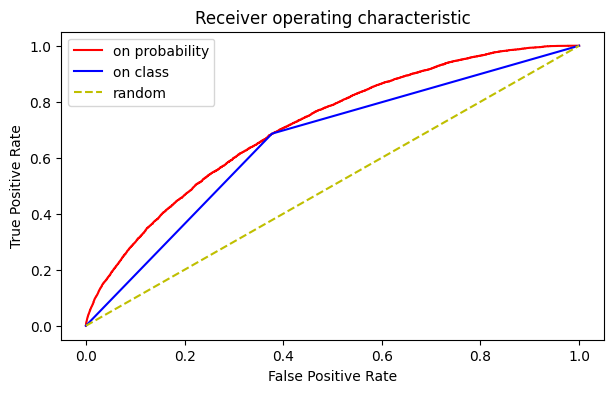

In [58]:
print('Metrics of the best model on the test set:')
print_metrics(final_pipeline, X_test, y_test, best_threshold, show_roc_curve=True)

### Training on all data

To analyze data processing and the importance of features, we split the final pipeline into a preprocessor and a model and train them on all data. And before saving the model, let's combine it back.

In [59]:
final_model = final_pipeline.named_steps['model']
final_preprocessor = final_pipeline.set_params(model=None)

In [60]:
sessions_preprocessed = final_preprocessor.fit_transform(sessions)

In [61]:
final_model.fit(sessions_preprocessed, target);

### Data processing analysis

As a result of all transformations, 62 features are obtained, despite the fact that another 16 features were removed due to correlations, etc.

The dataset has 175,034 duplicates, but experiments have shown that removing duplicates from the training set leads to a slight deterioration in the metrics.

There are no features correlated with the target variable.

In [62]:
sessions_preprocessed.head()

,visit_number,visit_date_weekday,visit_date_weekend,visit_date_day,visit_time_hour,visit_time_minute,visit_time_night,utm_medium_added_is_organic,utm_source_added_is_social,device_screen_resolution_width,device_screen_resolution_height,device_screen_resolution_ratio,geo_city_added_is_moscow_region,geo_city_added_is_big,geo_city_is_big_or_in_moscow_region,geo_city_added_distance_from_moscow,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_source_MvfHsxITijuriZxsqZqt,utm_source_kjsLglQLzykiRbcDiGcD,utm_source_rare,utm_source_fDLlAcSmythWSCVMvqvL,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_bByPQxmDaMXgpHeypKSM,utm_medium_cpm,utm_medium_cpc,utm_medium_rare,utm_medium_referral,utm_campaign_LEoPHuyFvzoNfnzGgfcd,utm_campaign_(nan),utm_campaign_gecBYcKZCPMcVYdSSzKP,utm_campaign_rare,utm_adcontent_vCIpmpaGBnIQhyYNkXqp,utm_adcontent_xhoenQgDQsgfEPYNPwKO,utm_adcontent_rare,utm_adcontent_(nan),utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_puhZPIYqKXeFPaUviSjo,utm_keyword_rare,device_category_desktop,device_os_Android,device_os_iOS,device_os_Windows,device_brand_Huawei,device_brand_Samsung,device_brand_Xiaomi,device_brand_Apple,device_brand_rare,device_browser_Chrome,device_browser_rare,device_browser_Safari,device_browser_YaBrowser,device_browser_Safari (in-app),geo_country_Russia,geo_city_rare,geo_city_Moscow,geo_city_Saint Petersburg,geo_city_(not set),geo_city_added_distance_from_moscow_category_1000-3000 km,geo_city_added_distance_from_moscow_category_>= 3000 km,geo_city_added_distance_from_moscow_category_500-1000 km,geo_city_added_distance_from_moscow_category_100-500 km,geo_city_added_distance_from_moscow_category_no distance
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9055434745589932991.1637753792.1637753792,-0.585990,-0.311302,0.0,0.803575,0.014750,1.339048,0.0,0.0,0.0,-0.829017,-0.686586,-0.311484,0.0,0.0,0.0,1.193088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
905544597018549464.1636867290.1636867290,-0.585990,1.485929,1.0,-0.307346,-0.957672,1.163018,1.0,0.0,1.0,-0.447866,0.183252,-0.789287,0.0,1.0,1.0,-0.885489,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9055446045651783499.1640648526.1640648526,-0.585990,-0.877065,0.0,1.234404,-1.803240,1.382257,1.0,0.0,0.0,-0.829017,-0.686586,-0.311484,0.0,1.0,1.0,1.407094,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9055447046360770272.1622255328.1622255328,-0.585990,1.084097,1.0,1.341147,-1.400897,-0.822162,1.0,0.0,0.0,-0.342270,-0.242671,-0.311484,0.0,1.0,1.0,-0.885489,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9055447046360770272.1622255345.1622255345,1.373905,1.084097,1.0,1.341147,-1.400897,-0.822162,1.0,0.0,0.0,-0.342270,-0.242671,-0.311484,0.0,1.0,1.0,-0.885489,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
sessions_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1860042 entries, 9055434745589932991.1637753792.1637753792 to 9055430416266113553.1640968742.1640968742
Data columns (total 62 columns):
 #   Column                                                     Dtype  
---  ------                                                     -----  
 0   visit_number                                               float64
 1   visit_date_weekday                                         float64
 2   visit_date_weekend                                         float64
 3   visit_date_day                                             float64
 4   visit_time_hour                                            float64
 5   visit_time_minute                                          float64
 6   visit_time_night                                           float64
 7   utm_medium_added_is_organic                                float64
 8   utm_source_added_is_social                                 float64
 9   device_screen_resolut

In [64]:
print('Number of duplicates:', sessions_preprocessed.duplicated().sum())

Number of duplicates: 175034


In [65]:
print('Correlation with target variable:')
correlation = pd.concat([sessions_preprocessed, target], axis=1).corr()
correlation['target'].sort_values(ascending=False, key=abs).head(5)

Correlation with target variable:


target                                1.000000
utm_medium_added_is_organic           0.050813
utm_medium_referral                   0.049207
utm_adcontent_JNHcPlZPxEMWDnRiyoBf    0.044788
utm_source_bByPQxmDaMXgpHeypKSM       0.040561
Name: target, dtype: float64

### Feature importance

After the conversion, the most important features turned out to be numerical variables: day (of months and weeks), hour, minute (most likely the zero minute of the hour) and visit number, screen size and distance to Moscow.

After these signs, the importance of the rest drops greatly. Perhaps this is the peculiarity of working with categorical features (especially with a large number of unevenly distributed unique values).

The most important initial features turned out to be: screen size, date, time and visit number, user's city, as well as features with additional data (as an indicator of organic traffic).

In [66]:
print('Features removed during feature selection\n')
all = 0

for step in ('constant_dropper', 'duplicated_dropper', 'correlated_dropper'):
    print(step + ':')
    for column in final_preprocessor.named_steps[step].features_to_drop_:
        print(f'\t{column}')
        all += 1

print('Total removed:', all)

Features removed during feature selection

constant_dropper:
	visit_date_added_holiday
	device_screen_resolution_area
	device_category_tablet
	device_os_rare
	device_model_(nan)
duplicated_dropper:
	geo_city_added_distance_from_moscow_category_moscow
	utm_medium_(none)
correlated_dropper:
	device_screen_resolution_ratio_greater_1
	device_os_(nan)
	utm_medium_banner
	geo_city_added_distance_from_moscow_category_< 100 km
	device_brand_(nan)
	utm_keyword_(nan)
	utm_campaign_FTjNLDyTrXaWYgZymFkV
	utm_campaign_LTuZkdKfxRGVceoWkVyg
	device_category_mobile
Total removed: 16


In [67]:
feature_importance = pd.Series(
    data=final_model.feature_importances_, 
    index=sessions_preprocessed.columns)

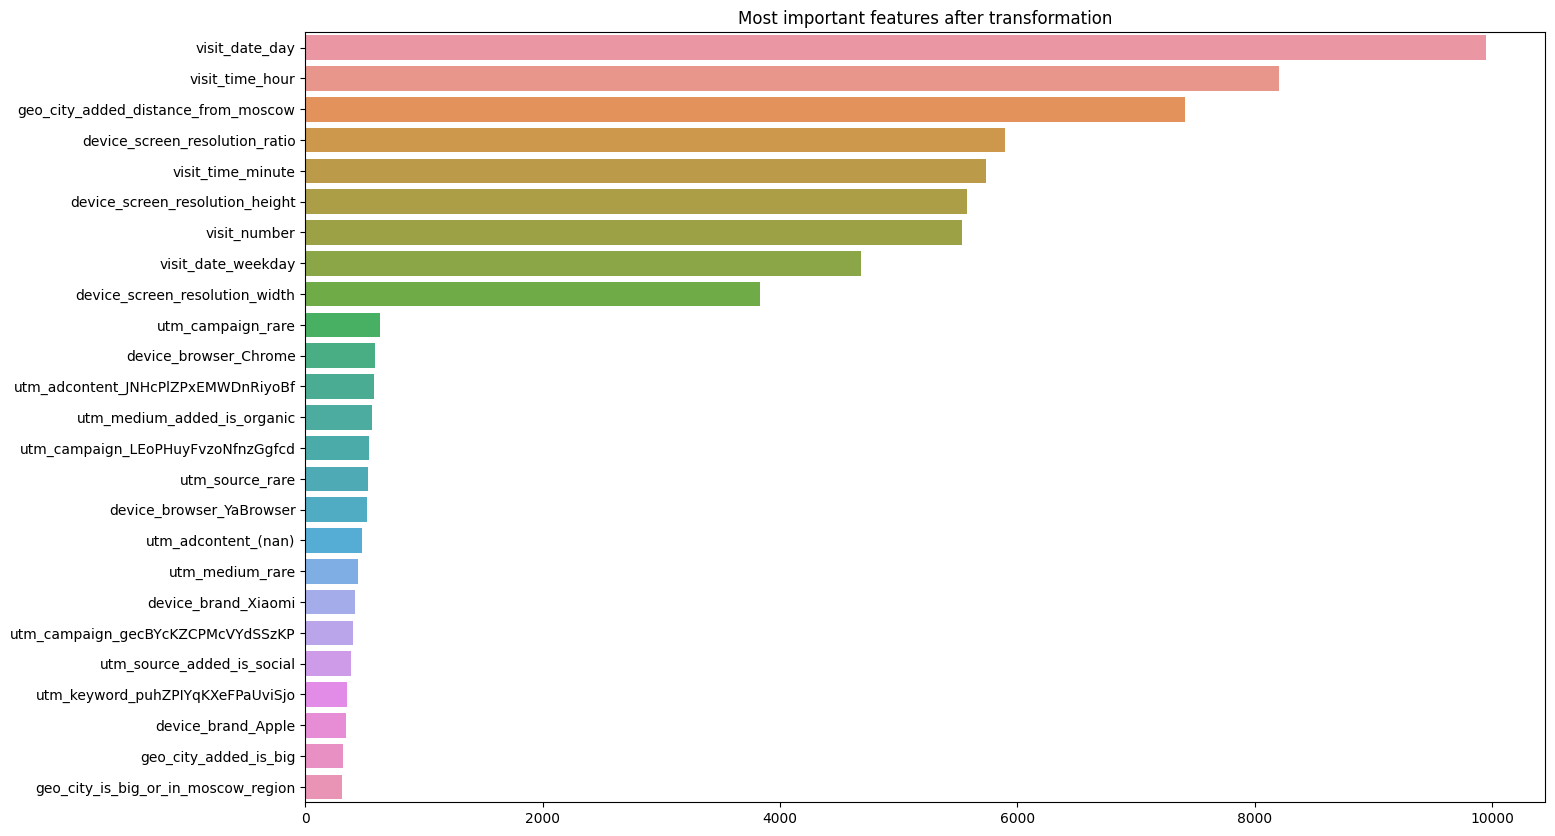

In [68]:
plt.figure(figsize=(16, 10))
most_important = feature_importance.sort_values(ascending=False).head(25)
sns.barplot(x=most_important, y=most_important.index, orient='h')
plt.title('Most important features after transformation');

In [69]:
# From the importance of derived features, we get the importance of the original
# Also get the importance of features with added data

original_columns = list(sessions.columns) + ['_added_']
column_importances = list()
for col in original_columns:
    imp = feature_importance[feature_importance.index.str.contains(col)].sum()
    column_importances.append(imp)

column_importances = pd.Series(column_importances, index=original_columns)
column_importances.sort_values(ascending=False, inplace=True)

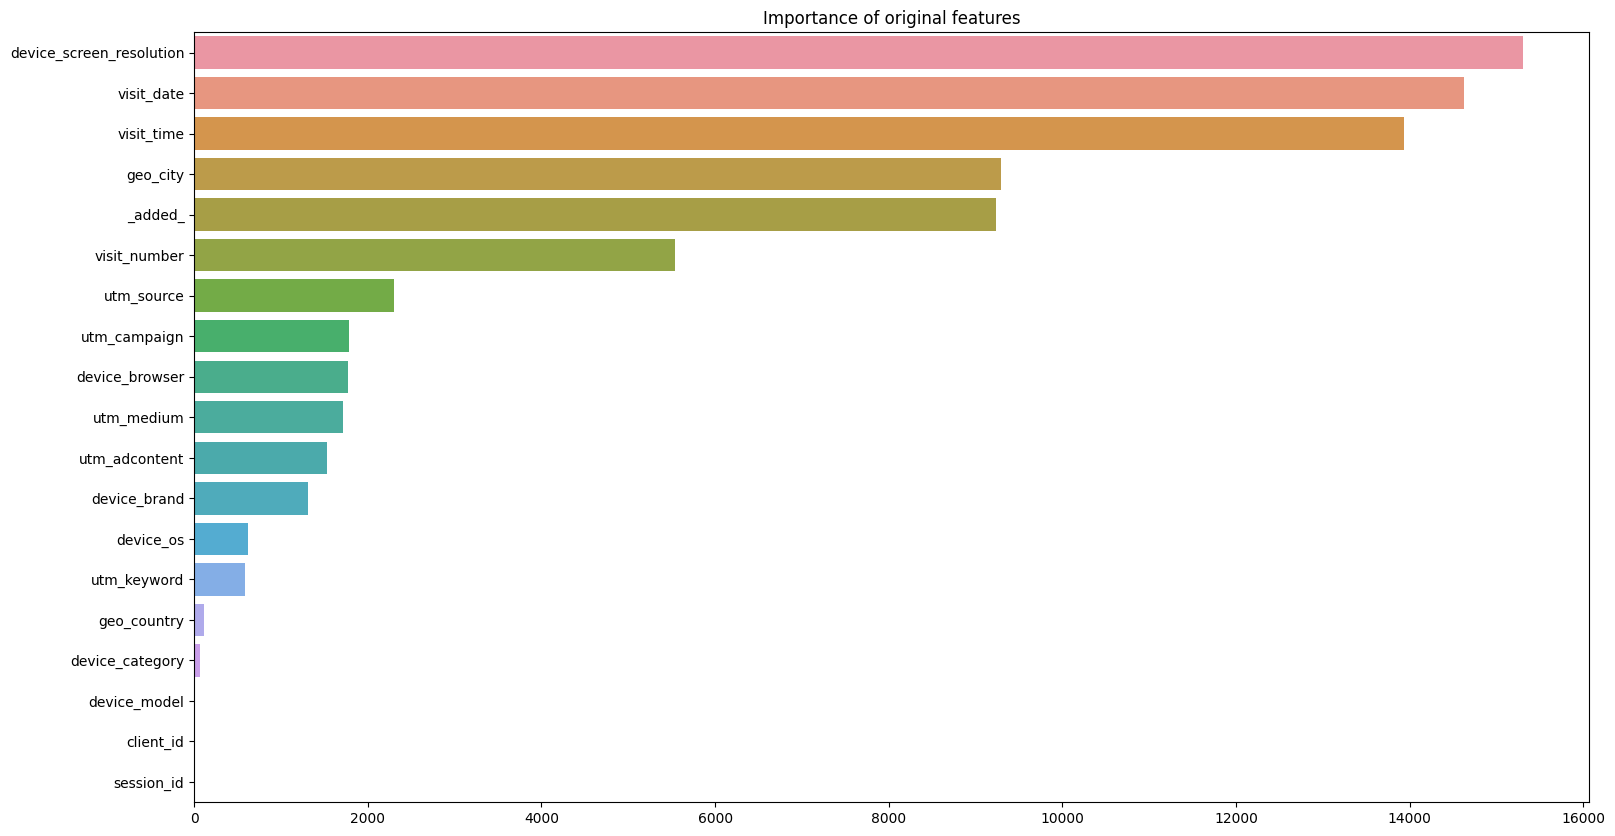

In [70]:
plt.figure(figsize=(18, 10))
sns.barplot(x=column_importances, y=column_importances.index, orient='h')
plt.title('Importance of original features');

### Saving the model

In [71]:
# Merge preprocessor and model back

final_pipeline = final_preprocessor.set_params(model=final_model)

In [72]:
# Add metadata for the model

metadata = {
    'name': 'SberAutopodpiska: target event prediction',
    'descripton': ('Model for predicting whether the user will do one of the '
                   'target actions "Order a call" or "Leave a request" '
                   'on the website of the SberAutopodpiska service.'),
    'model_type': final_model.__class__.__name__, 
    'version': 1.1, 
    'training_datetime': datetime.now(), 
    'author': 'Mykhailo Kafka', 
    'threshold': best_threshold, 
    'metrics': {
        'roc_auc': roc_auc_score(y_test, test_proba), 
        'roc_auc_by_class': roc_auc_score(y_test, test_prediction),
        'accuracy': accuracy_score(y_test, test_prediction), 
        'precision': precision_score(y_test, test_prediction), 
        'recall': recall_score(y_test, test_prediction), 
        'f1': f1_score(y_test, test_prediction),
    }
}

final_pipeline.metadata = metadata

In [ ]:
# Saving model

filename = f'model_{datetime.now():%Y%m%d%H%M%S}.pkl'

with open(filename, 'wb') as file:
    dill.dump(final_pipeline, file)

## Conclusions

It took four steps to transform the input data, with the structure as in the `ga_sessions.csv` file, into a form convenient for prediction:
1. Fill in the gaps and generate features. Including adding new data, such as organic traffic or distance to Moscow.
2. Transformation of numerical variables: normalization and removal of outliers.
3. Transformation of categorical features. The main difficulty with them was in the variety of rare unique values. As a result, only the most popular values were encoded using the one-hot method.
4. Removal of duplicate and correlated features. Features can correlate up to 0.95, but it is with this threshold that the final model gives the best result.

10 models were tested with default hyperparameters. The top three were boosting algorithms from sklearn, lightgbm and catboost.

As a result, `LightGBM` was chosen as the best model for the following reasons:
+ One of the best indicators of `roc_auc`.
+ Fast learning.
+ The model is interpretable, that is, you can get indicators of the importance of features.
+ Can predict class probability.
+ No problems with processors without SSE4 like CatBoost.

The model optimization step helped to select the best hyperparameters for the model: n_estimators=800, learning_rate=0.07, reg_lambda=10, num_leaves=26, reg_alpha=10, boosting_type='goss'.

The quality of the model by the `roc-auc` metric is **0.7148** (0.6535 for class prediction). But the metric `f1`=0.0871 leaves much to be desired. However, there is no retraining and the project goal is met - `roc-auc` > 0.65.

To improve the quality of the prediction one could:
1. Increase the amount of data. The test sample will be used to retrain the model, so the model may be better in the end.
2. Rebalance classes. But if you reduce the sample with a negative target variable, then the model loses quality, and if you increase the sample with a positive class, then the models are trained for too long.
3. Conduct a more thorough search for the best hyperparameters - this will take a lot of time, and the quality gain will be small.
4. Carry out additional feature generation. But good ideas are hard to come up with.
5. Try more complex models, such as deep learning neural networks.